In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk. corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('amazon_alexa.tsv', sep = '\t', quoting =3)
data

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [4]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [5]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [6]:
data.dropna(inplace = True)

In [7]:
data['length'] = data.verified_reviews.apply(len)
data

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,382


In [8]:
 print(f'random_check; Column Value: {data.iloc[50]['verified_reviews']}')
 print(f'random_check; Length of Column Value: {len(data.iloc[50]['verified_reviews'])}')
 print(f'random_check; Column Value: {data.iloc[50]['length']}')

random_check; Column Value: "Excelente, lo unico es que no esta en español."
random_check; Length of Column Value: 48
random_check; Column Value: 48


In [9]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [10]:
data.rating.value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

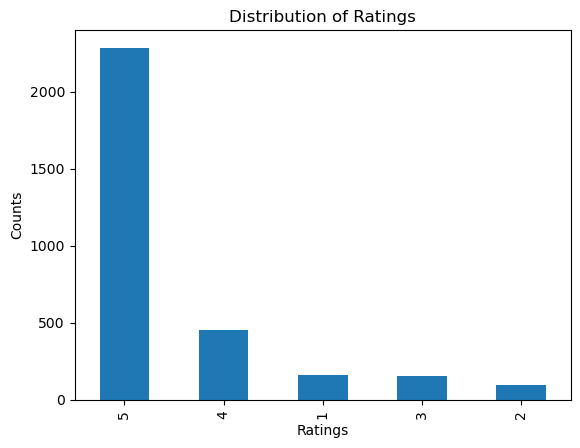

In [11]:
data.rating.value_counts().plot(kind= 'bar')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.show()

In [12]:
#Percentage of ratings
percent = round((data.rating.value_counts()/len(data))*100, 2)
percent

rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64

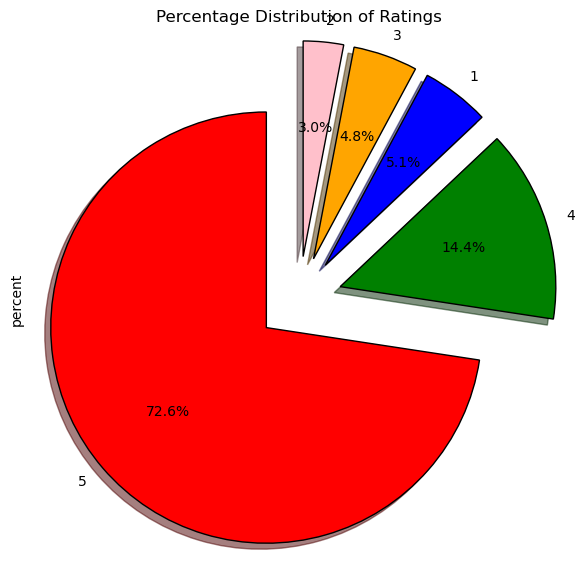

In [13]:
plt.figure(figsize = (7,7))
colors = ('red', 'green', 'blue', 'orange', 'pink')
explode = (0.2, 0.2, 0.2, 0.2, 0.2)
tag = data.rating.value_counts()/data.shape[0]
wp ={'linewidth': 1, 'edgecolor': 'black'}
tag.plot(kind = 'pie', shadow = True, colors=colors, startangle=90, label= 'percent', autopct= '%1.1f%%', wedgeprops = wp, explode= explode, 
         title='Percentage Distribution of Ratings')
plt.show()

In [14]:
print(f'Feedback Value Counts: \n{data.feedback.value_counts()}')

Feedback Value Counts: 
feedback
1    2893
0     256
Name: count, dtype: int64


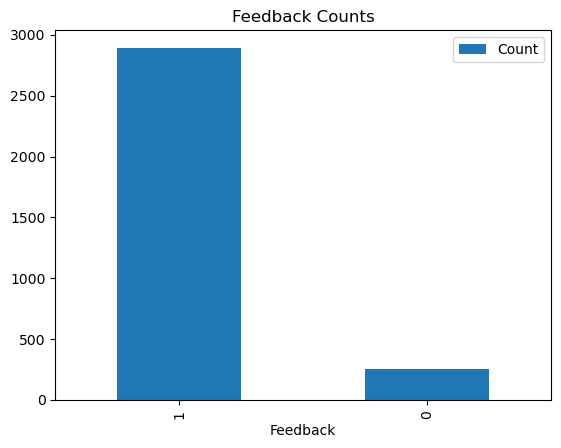

In [15]:
tag = data.feedback.value_counts().reset_index()
tag.columns = ['Feedback', 'Count']
tag.set_index('Feedback').plot(kind='bar', title = 'Feedback Counts')
plt.show()

In [16]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback',
       'length'],
      dtype='object')

In [17]:
review = data[data.feedback == 0].iloc[4]['verified_reviews']
review

'Sad joke. Worthless.'

In [18]:
review = data[data.feedback == 1].iloc[23]['verified_reviews']
review

'I love it. It plays my sleep sounds immediately when I ask'

In [19]:
# Ratings that gives negative feedback
negative_rating = data[data.feedback == 0]['rating'].value_counts()
negative_rating

rating
1    161
2     95
Name: count, dtype: int64

In [20]:
# Ratings that gives positive feedback
negative_rating = data[data.feedback == 1]['rating'].value_counts()
negative_rating

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [21]:
data.variation.value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

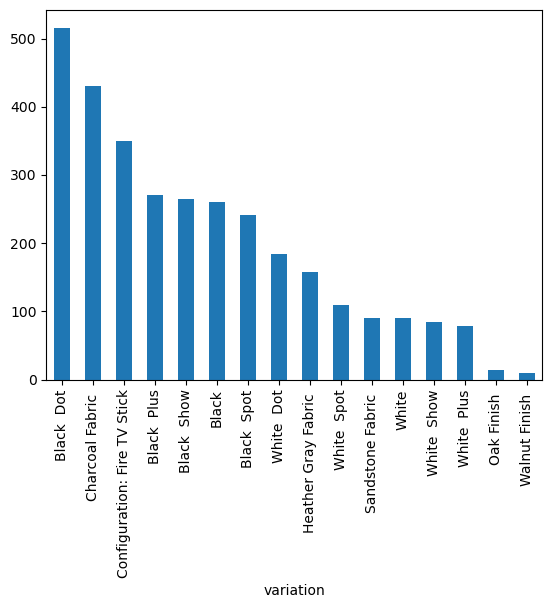

In [22]:
data.variation.value_counts().plot(kind = 'bar')
plt.show()

In [23]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

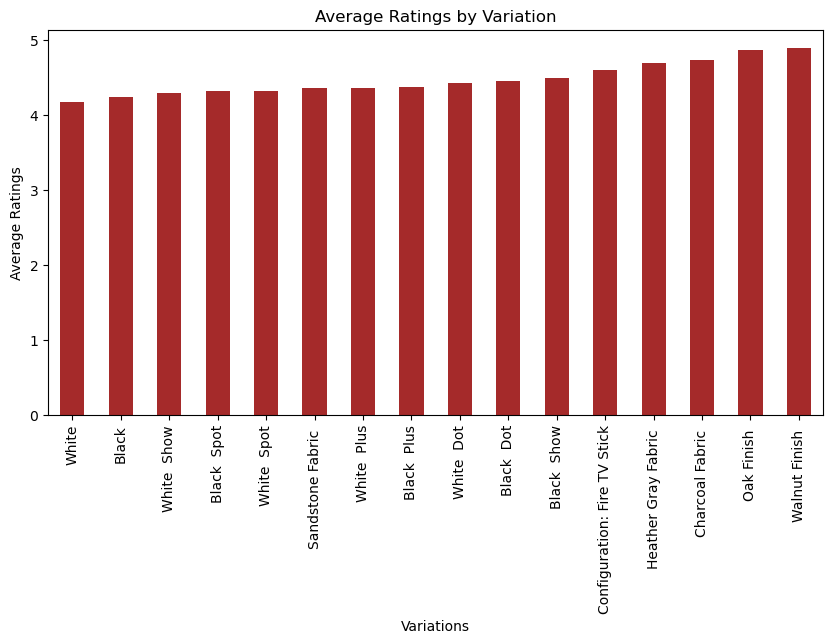

In [24]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(figsize = (10, 5), color = 'brown')
plt.title('Average Ratings by Variation')
plt.xlabel('Variations')
plt.ylabel('Average Ratings')
plt.show()

In [25]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [26]:
def clean_text(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)  # return only the word in the square bracket, don't include the square bracket 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # delete punctuations i.e remove special xters
    text = re.sub('\w*\d\w*', '', text) #delete any word that contains digit.
    
    return text

cleaned1 = lambda x: clean_text(x)

In [27]:
data['Clean_Description'] = data['verified_reviews'].apply(cleaned1)
data.head()

,rating,date,variation,verified_reviews,feedback,length,Clean_Description
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13,love my echo
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9,loved it
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197,sometimes while playing a game you can answer ...
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174,i have had a lot of fun with this thing my yr...
4,5,31-Jul-18,Charcoal Fabric,Music,1,5,music


In [28]:
def clean_text1(text):
    text = re.sub('[ ''"".... ]', '', text)
    text = re.sub('\n', '', text)
    return text

cleaned2 = lambda x: clean_text(x)

In [29]:
data['cleaned_verified_reviews'] = data.Clean_Description.apply(cleaned2)
data.head()

,rating,date,variation,verified_reviews,feedback,length,Clean_Description,cleaned_verified_reviews
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13,love my echo,love my echo
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9,loved it,loved it
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197,sometimes while playing a game you can answer ...,sometimes while playing a game you can answer ...
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174,i have had a lot of fun with this thing my yr...,i have had a lot of fun with this thing my yr...
4,5,31-Jul-18,Charcoal Fabric,Music,1,5,music,music


In [30]:
data.cleaned_verified_reviews.describe()

count     3149
unique    2244
top           
freq        79
Name: cleaned_verified_reviews, dtype: object

In [31]:
data['length_new'] = data.cleaned_verified_reviews.apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length,Clean_Description,cleaned_verified_reviews,length_new
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13,love my echo,love my echo,12
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9,loved it,loved it,8
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197,sometimes while playing a game you can answer ...,sometimes while playing a game you can answer ...,192
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174,i have had a lot of fun with this thing my yr...,i have had a lot of fun with this thing my yr...,167
4,5,31-Jul-18,Charcoal Fabric,Music,1,5,music,music,5


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   rating                    3149 non-null   int64 
 1   date                      3149 non-null   object
 2   variation                 3149 non-null   object
 3   verified_reviews          3149 non-null   object
 4   feedback                  3149 non-null   int64 
 5   length                    3149 non-null   int64 
 6   Clean_Description         3149 non-null   object
 7   cleaned_verified_reviews  3149 non-null   object
 8   length_new                3149 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 246.0+ KB


In [33]:
data['length_new'].describe()

count    3149.000000
mean      127.471261
std       175.425432
min         0.000000
25%        28.000000
50%        71.000000
75%       161.000000
max      2567.000000
Name: length_new, dtype: float64

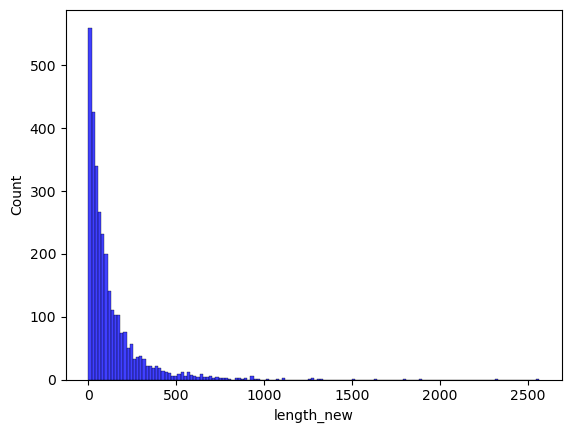

In [34]:
sns.histplot(data = data['length_new'], color = 'blue')
plt.show()

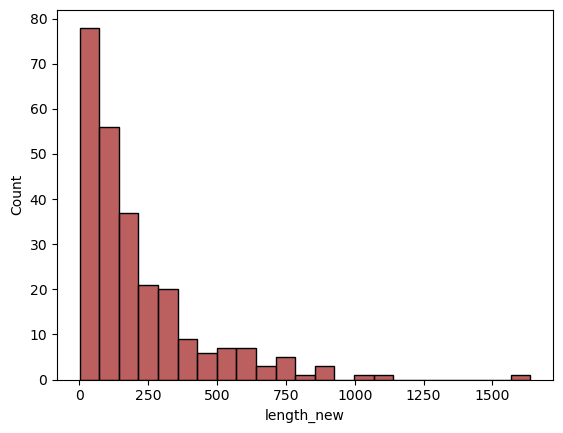

In [35]:
sns.histplot(data = data[data['feedback'] == 0]['length_new'], color = 'brown')
plt.show()

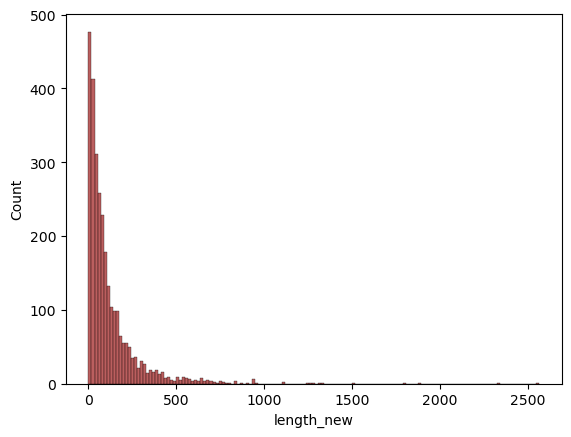

In [36]:
sns.histplot(data = data[data['feedback'] == 1]['length_new'], color = 'brown')
plt.show()

In [37]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback', 'length',
       'Clean_Description', 'cleaned_verified_reviews', 'length_new'],
      dtype='object')

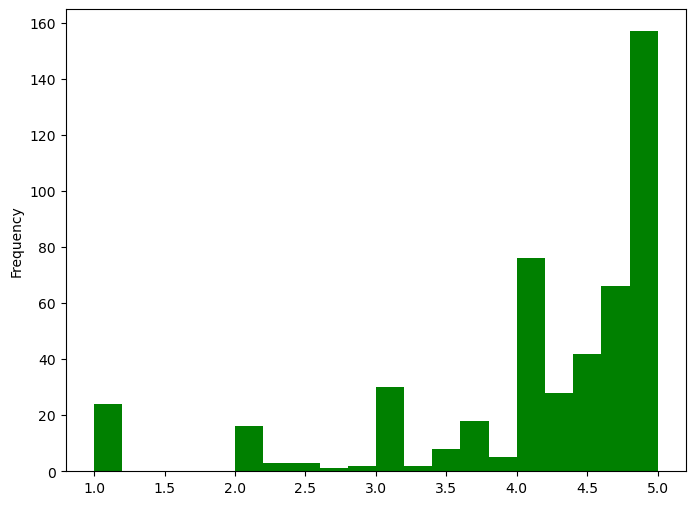

In [38]:
data.groupby('length_new')['rating'].mean().plot.hist(color = 'green', bins = 20, figsize = (8,6))
plt.show()

In [39]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(data.cleaned_verified_reviews)

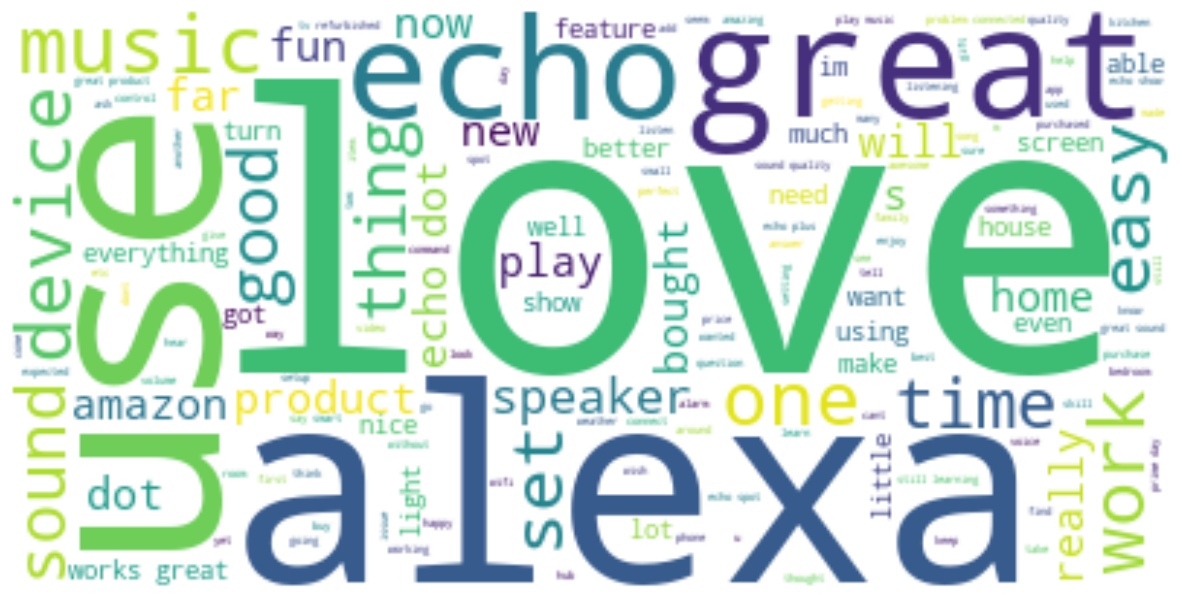

In [40]:
reviews = " ".join([text for text in data.cleaned_verified_reviews])
wc = WordCloud(background_color='white', max_words = 150)
plt.figure(figsize = (15,12))
plt.imshow(wc.generate(reviews), interpolation='bilinear')
plt.axis('off')
plt.show()

In [41]:
neg_reviews = " ".join([text for text in data[data['feedback']==0]['cleaned_verified_reviews']])
neg_reviews = neg_reviews.split()
#neg_reviews

In [42]:
post_reviews = " ".join([text for text in data[data['feedback']==1]['cleaned_verified_reviews']])
post_reviews = post_reviews.split()
#post_reviews

In [43]:
unique_neg = [text for text in neg_reviews if text not in post_reviews]
unique_neg = ' '.join(unique_neg)
#unique_neg

In [44]:
unique_post = [text for text in post_reviews if text not in neg_reviews]
unique_post = ' '.join(unique_post)
#unique_post

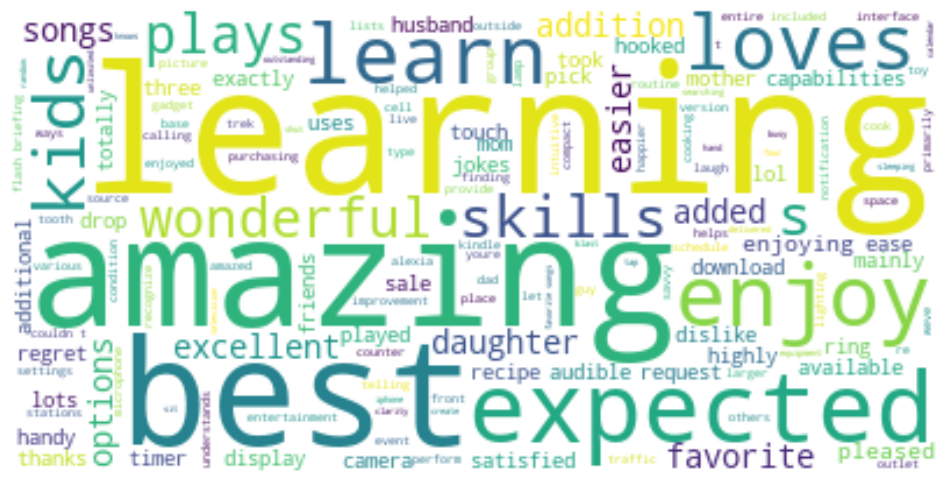

In [45]:
wc = WordCloud(background_color='white', max_words = 150)
plt.figure(figsize = (12,9))
plt.imshow(wc.generate(unique_post), interpolation='bilinear')
plt.axis('off')
plt.show()

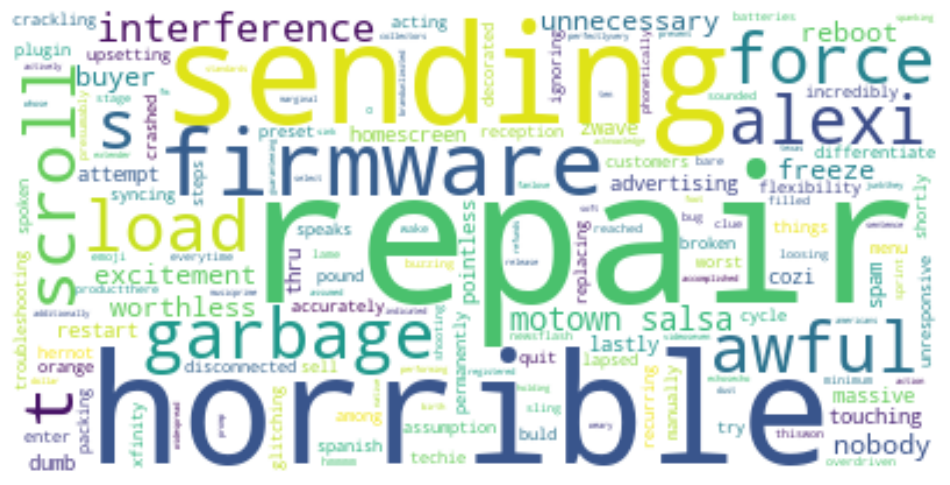

In [46]:
wc = WordCloud(background_color='white', max_words = 150)
plt.figure(figsize = (12,9))
plt.imshow(wc.generate(unique_neg), interpolation='bilinear')
plt.axis('off')
plt.show()

## Data Preprocessing and Model Building

In [47]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
corpus = []
stemmer = PorterStemmer()
wordnet = WordNetLemmatizer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['cleaned_verified_reviews'])
    review = review.lower().split()
    review = [wordnet.lemmatize(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [48]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback', 'length',
       'Clean_Description', 'cleaned_verified_reviews', 'length_new'],
      dtype='object')

In [49]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(corpus).toarray()
y = data.feedback.values
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [50]:
X.shape

(3149, 2500)

In [51]:
y.shape

(3149,)

# pickle.dump(cv, open('Models\countvectorizer.pkl', 'wb'))
with open('data.pkl', 'wb') as file:
    pickle.dump(cv, file)

In [52]:
import os
os.makedirs('Models', exist_ok=True)

In [53]:
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 76)
X_train.shape

(2204, 2500)

In [55]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [57]:
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [58]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [59]:
print('Training Accuracy:', model_rf.score(X_train_scl, y_train))
print('Test Accuracy:', model_rf.score(X_test_scl, y_test))

Training Accuracy: 0.9936479128856625
Test Accuracy: 0.9365079365079365


In [60]:
y_pred = model_rf.predict(X_test_scl)

In [61]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 20,  54],
       [  6, 865]], dtype=int64)

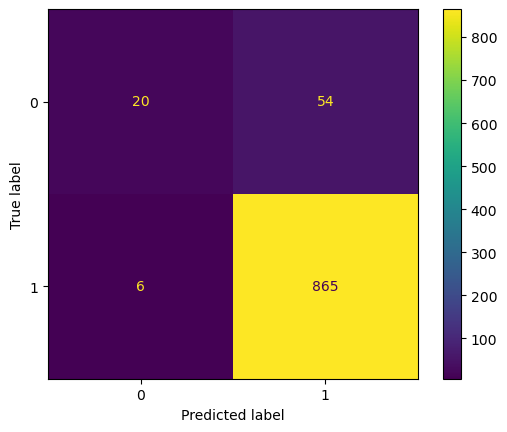

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_rf.classes_)
cm_display.plot()
plt.show()

#Grid Search
params = {
        'bootstrap': [True],
        'max_depth': [80, 100],
        'min_samples_split': [8, 12],
        'n_estimators': [100, 300]         
         }

cv_object = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator = model_rf, cv = cv_object, param_grid = params, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

print(f'best parameter combination is: {grid_search.best_params_}')
print(f'mean_test_score: {grid_search.cv_results_['mean_test_score'].mean()*100}') 
print(f'mean_train_score: {grid_search.cv_results_['mean_train_score'].mean()*100}') 

In [63]:
model_rf = RandomForestClassifier(
bootstrap = True, 
max_depth = 80, 
min_samples_split = 8,
n_estimators = 300
)
model_rf.fit(X_train_scl, y_train)
y_pred = model_rf.predict(X_test_scl)
print('Training Accuracy:', model_rf.score(X_train_scl, y_train))
print('Test Accuracy:', model_rf.score(X_test_scl, y_test))

Training Accuracy: 0.971415607985481
Test Accuracy: 0.926984126984127


## XGBoosting

In [64]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)
y_pred = model_xgb.predict(X_test_scl)
print('Training Accuracy:', model_xgb.score(X_train_scl, y_train))
print('Test Accuracy:', model_xgb.score(X_test_scl, y_test))

Training Accuracy: 0.9718693284936479
Test Accuracy: 0.9365079365079365


#Grid Search
params = {
    'n_estimators': [500, 800],
    'max_depth': [10, 20],  # Keep values lower to avoid overfitting
    'min_child_weight': [1, 3],
    'gamma': [0.5, 1],
    #'subsample': [0.6, 0.8, 1.0],
    #'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1]
}
cv_object = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator = model_xgb, cv = cv_object, param_grid = params, verbose = 1, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

print(f'best parameter combination is: {grid_search.best_params_}')
print(f'mean_test_score: {grid_search.cv_results_['mean_test_score'].mean()*100}') 
print(f'mean_train_score: {grid_search.cv_results_['mean_train_score'].mean()*100}') 

In [78]:
model_xgb = XGBClassifier(
gamma = 0.6, 
learning_rate = 0.1, 
max_depth = 40,
min_child_weight = 1, 
n_estimators = 1000
)
model_xgb.fit(X_train_scl, y_train)
y_pred = model_xgb.predict(X_test_scl)
print('Training Accuracy:', model_xgb.score(X_train_scl, y_train))
print('Test Accuracy:', model_xgb.score(X_test_scl, y_test))

Training Accuracy: 0.971415607985481
Test Accuracy: 0.9396825396825397


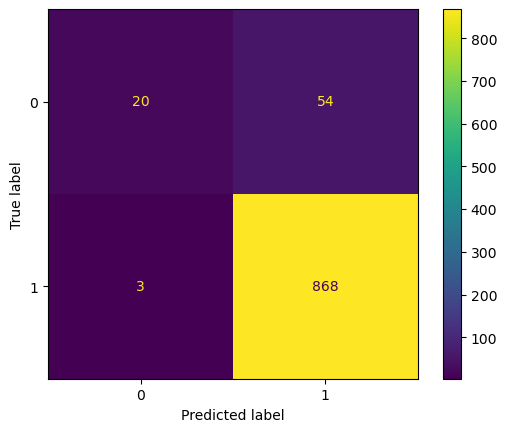

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_xgb.classes_)
cm_display.plot()
plt.show()

In [81]:
pickle.dump(model_xgb, open('Models\model_xgb.pkl', 'wb'))

In [82]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)
print(f'Training Accuracy: {model_dt.score(X_train_scl, y_train)}')
print(f'Test Accuracy: {model_dt.score(X_test_scl, y_test)}')

Training Accuracy: 0.9936479128856625
Test Accuracy: 0.9259259259259259
